# Assignment: wave equation

Write some code to solve the wave equation in 1D, with periodic boundaries.  You should find the $\nabla^2$ via the 1D central difference method. 

Remember that the purpose here is not to change $\phi$ such that $\nabla^2 \phi=0$ but to find $\nabla^2$ and use it to step forward the velocities, at the same time using the velocities to step forward $\phi$.  To spell this out as an algorithm, it should be something like this:

0.  Initialise $\vec{\phi}$ and $\vec{v}$. 
1.  Find $\nabla^2 \vec{\phi}$
2.  Update $\vec{v}$ using $\nabla^2 \vec{\phi}$
3.  Update $\vec{\phi}$ using $\vec{v}$
4.  Back to (1)

**(1)** Initialise your system with a sinusoid for $\phi$.  Your output for the first question is only to plot the curvature and amplitude for $\phi$ on the same axis at $t=0$.  

**(2)** The potential energy stored in a wave is proportional to $\frac{1}{2}\int [\nabla \Phi]^2 \,{\rm d}x $ and the kinetic energy goes as $\frac{1}{2}\int [\frac{\partial \Phi}{\partial t}]^2 \,{\rm d}x $.  You may assume that definite integrals $\int_a^b f(x) \,{\rm d}x$ can be approximated using a simple first-order Euler method: $\int f(x) \,{\rm d}x \approx \sum_i f(x_i)\frac{(x_{i+1}-x_{i-1})}{2h}$.

Make a plot of the time series of the kinetic, potential and total energy over two full time periods of your wave oscillation.  Show results for a few values of $N$ on the same axis to test that your code conserves energy (total KE and PE is constant) and is stable.  

For small $N$ it should be obvious that forward difference doesn't actually conserve energy very well, for large $N$ I would expect to see an improvement.   



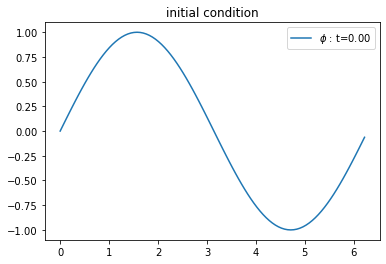

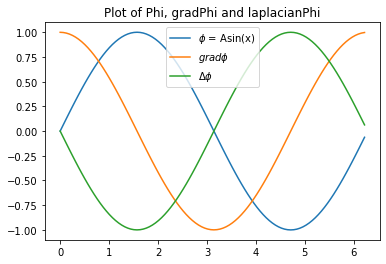

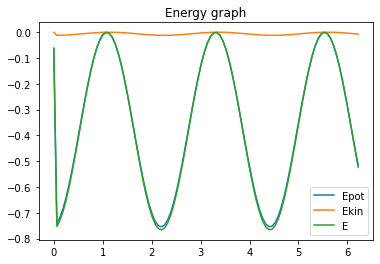

In [30]:
#You should set up your code something like this.  
#You might need to change the h and dt if your code shows radically bad conservation of energy.
    
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#########
N    = 100  ##number of points: more points means smaller h, so use something like 10-100 for fast debug.
#########

###this setup all depends on N.
interval = 2*np.pi ## gives us some freedom on the interval
h     = interval/N         ##set length == 2 pi metres.
dt    = h*h               ##second order in x, first order in t, so dt needs to be smaller than h.
in_x  = np.arange(0., interval, h)  ##x coordinates of the points.
amplitude = 1 ## might as well add a fun constant
phi   = np.sin(in_x) * amplitude      ##might as well pick a wave as the initial condition
v     = np.zeros((N))     ##might as well pick zero velocity as the initial condition.
time  = 0.
t_max = np.pi * 3  ##one period should be 2pi units of time in our dimensionless system.
    
plt.title("initial condition")
plt.plot(in_x, phi, label="$\phi$ : t=%.2f" % time)
plt.legend()
plt.show()    
    
#.
#.  do the exercise below here...
#.


## introducing a class to contain all our differentiation functions
class Differentiator():
    """
    This class contains both our gradient operator and laplacian operator
    """
    def __init__( self, N_in ):
        
        self.N = N_in
        self.gradientOperator = np.zeros((N,N))
        self.laplacianOperator = np.zeros((N,N))
        dx = 2*np.pi/self.N
        
        ## defining the gradient
        for i in range(N):
            self.gradientOperator[i,(i+1)%N] =  1.0
            self.gradientOperator[i,(i-1)%N] = -1.0
        self.gradientOperator /= (2*dx)
        
        ## defining the laplacian
        for i in range(N):
            self.laplacianOperator[i,i] = -2.
            self.laplacianOperator[i,(i+1)%N] = 1.
            self.laplacianOperator[i,(i-1)%N] = 1.
        self.laplacianOperator /= dx**2
    
    ## the function applying the gradient operator
    def gradient(self, y):
        gradient = self.gradientOperator @ y
        
        return gradient
    
    ## the function applying the laplacian operator
    def laplacian(self, y):
        laplacian = self.laplacianOperator @ y
        
        return laplacian

## euler-method integration
def integralCalculator(f,N):
    integralValue = 0 ##initializing the integral value
    
    for i in range(N-1): ## basically the sum as described in the formula
        integralValue += f[i] * (in_x[i+1]-in_x[i-1])/2 ## no need to divide by h, as it is already contained in x
    
    return integralValue ## returning the value of our integral

## calling an instance of the class
diff = Differentiator(N)

## getting the values
gradientPhi = diff.gradient(phi)
laplacianPhi = diff.laplacian(phi)

## plotting phi, grad(phi) and laplacian(phi)
plt.title("Plot of Phi, gradPhi and laplacianPhi")
plt.plot(in_x, phi, label = "$\phi$ = Asin(x)")
plt.plot(in_x, gradientPhi, label = "$ grad \phi$")
plt.plot(in_x, laplacianPhi, label = "$ \Delta \phi$")
plt.legend()
plt.show()


## determination of the speed, potential and kinetic energy

## initializing the needed lists
potentialEnergy = 0
potentialEnergyList = []
kineticEnergy = 0
kineticEnergyList = []
totalEnergy = 0
totalEnergyList = []


newV = []
newPhi = []
v2 = []

for i in range(N):
    newPhi.append('')
    newV.append('')
    v2.append('')

## calculating
for j in range(N):
    ## updating the lists with the formulas
    for i in range(N):
        newV[i] = v[i] + dt * diff.laplacian(phi)[i]
        newPhi[i] = phi[i] + dt * newV[i]
    
    ## had some funky behaviour with v**2 as argument of funtion, this seemed to fix it
    for i in range(N):
        v2[i] = v[i]**2

    ## computing the kinetic energy and storing in a list for plotting
    kineticEnergy = integralCalculator(v2,N)
    kineticEnergyList.append(kineticEnergy)
    
    ## computing the potential energy and storing in a list for plotting    
    potentialEnergy = integralCalculator(diff.gradient(phi)**2,N)
    potentialEnergyList.append(potentialEnergy)
    
    totalEnergy = potentialEnergy + kineticEnergy
    totalEnergyList.append(totalEnergy)
    
    ## updating our old lists for the next iteration
    phi = newPhi
    v = newV

    ## resetting our lists
    for i in range(N-1):
        newV[i] = 0
        newPhi[i] = 0
    potentialEnergy = 0
    kineticEnergy = 0

plt.title("Energy graph")
plt.plot(in_x, potentialEnergyList, label = "Epot")
plt.plot(in_x, kineticEnergyList, label = "Ekin")
plt.plot(in_x, totalEnergyList, label = "E")
plt.legend()
plt.show()

